### 2022/1/31 Example for cell wall analysis

- with the help of YK's modification, Chen has tried to improve accuracy for tracking the deformation of cell wall

- The area, eccentricty, major/minor axis length, vertical/horizontal length of bounding box and maxium feret of cell wall during micro three-point bending test and their change rate were visualized

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import os
import mahotas as mh
from skimage.measure import label, regionprops, regionprops_table
import natsort  ## package for naturally sort name 
from tqdm import tqdm
import pandas as pd
import cv2
import trackpy as tp ## important package for particle tracking
import time #this function is used for measuring calculation times of each function
import gc
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
#set functions
#image loading
def load_im(target_dir, file_name):
    im = cv2.imread(os.path.join(target_dir, file_name))
    im = cv2.bitwise_not(im)
    im = cv2.cvtColor(im[:,:], cv2.COLOR_BGR2GRAY)
    
    return im

#watershed segmentation
def watershed_segmentation(im):
    #watershed segmentation
    locmax = mh.regmax(im)
    seeds, nr_nuclei = mh.label(locmax)
    T = mh.thresholding.otsu(np.uint8(im))
    dist = mh.distance(np.uint8(im) > T)
    dist = dist.max() - dist
    dist -= dist.min()
    dist = dist/float(dist.ptp()) * 255
    dist = dist.astype(np.uint8)
    nuclei, lines = mh.cwatershed(dist, seeds, return_lines=True)
    
    #parameters extraction-1
    nuclei_without_border = mh.labeled.remove_bordering(nuclei)
    nuclei_new = label(nuclei_without_border)
    
    return nuclei_new, lines


#extract positional data
def extract_centroids(nulcei):
    #use scikit image func
    props=regionprops(nuclei)
    centroids_y=[props[i].centroid[0].astype('float32') for i in range(len(props))]
    centroids_x=[props[i].centroid[1].astype('float32') for i in range(len(props))]
    labels=[np.int32(props[i].label) for i in range(len(props))]
    return centroids_y, centroids_x, labels


#extract the cells correctly tracked by the algorithm
def extract_cell_tracking_result(nuclei_list, track_result_filtered, check_number):
    #set 3D storage
    nuclei_track_result = np.zeros((nuclei_list[0].shape[0], nuclei_list[0].shape[1], check_number))
    
    #extract particle num satisfying check number
    frame_num_list=np.unique(track_result_filtered['frame'])
    
    for frame_num in tqdm(frame_num_list):
        #extract information of the certain frame
        track_result_certain_frame=track_result_filtered[track_result_filtered["frame"]==frame_num]
        
        #set target
        
        target_label=np.asarray(track_result_certain_frame["label"])
        target_particle=np.asarray(track_result_certain_frame["particle"])
        target_nuclei=list(nuclei_list[frame_num].flatten())
        
#         target_particle=np.asarray(track_result_certain_frame["particle"])
#         sort_index=np.argsort(target_particle)
#         target_label=np.asarray(track_result_certain_frame["label"])
#         target_label_sort=target_label[sort_index]
#         new_label=np.arange(1, 1+len(target_label_sort))
#         target_nuclei=list(nuclei_list[frame_num].flatten())
        
        #create temporary zero matrix
        zero_map=np.zeros((nuclei_list[0].shape[0]*nuclei_list[0].shape[1]))
        
        #set function
        #replace_func = {label: new for label, new in zip(target_label_sort, new_label)} 
        replace_func = {label: new for label, new in zip(target_label, target_particle)} 

        #replace label values to anatomical values
        replace_result=np.asarray(list(map(replace_func.get, target_nuclei)))
        result_index=np.where(replace_result!=None)[0]

        #project the result to zero map
        zero_map[result_index]=replace_result[result_index]

        #merge result of each frame to 3D storage
        nuclei_track_result[:,:,frame_num]=zero_map.reshape((nuclei_list[0].shape[0], nuclei_list[0].shape[1]))
        
    return nuclei_track_result


#function for visualization
def result_visualization(nuclei_list, track_result_filtered, change_rate_result):
    #set 3D storage
    result_map = np.zeros((nuclei_list[:,:,0].shape[0], nuclei_list[:,:,0].shape[1], len(change_rate_result)))
    
    #extract particle num satisfying check number
    frame_num_list=np.unique(track_result_filtered['frame'])
    
    for frame_num in tqdm(frame_num_list):
        #extract information of the certain frame
        track_result_certain_frame=track_result_filtered[track_result_filtered["frame"]==frame_num]        
        #set target
        #target_label=np.asarray(track_result_certain_frame["label"])
        #target_particle=np.asarray(track_result_certain_frame["particle"])
        new_label=np.unique(nuclei_list[:,:, frame_num])[1:]
        target_nuclei=list(nuclei_list[:,:, frame_num].flatten())
        target_change_rate_result=change_rate_result[frame_num]
        
        #set zero map
        zero_map=np.zeros((nuclei_list[:,:,0].shape[0]*nuclei_list[:,:,0].shape[1]))    

        #set function
        replace_func = {new: change_rate for new, change_rate in target_change_rate_result} 

        #replace label values to anatomical values
        replace_result=np.asarray(list(map(replace_func.get, target_nuclei)))
        result_index=np.where(replace_result!=None)[0]

        #project the result to zero map
        zero_map[result_index]=replace_result[result_index]

        #save result
        result_map[:,:,frame_num]=zero_map.reshape((nuclei_list[:,:,0].shape[0], nuclei_list[:,:,0].shape[1]))
        
    return result_map


def video(nucleis_true):
    fig = plt.figure()
    im = plt.imshow(nuclei_true[:,:,0], cmap=plt.get_cmap('jet'), vmin=0,)
    
    def updatefig(j):
        # set the data in the axesimage object
        im.set_array(nuclei_true[:,:,j])
        # return the artists set
        return [im]
    
    ani = animation.FuncAnimation(fig, updatefig, frames=nuclei_true.shape[2], interval=20, blit=True)
    return(ani)

In [3]:
specimen = 'r-H-5-SIFT'

In [4]:
target_dir = './cell_wall_deformation_large_image/' + specimen + '/'
filenames = natsort.natsorted([filename for filename in os.listdir(target_dir) if not filename.startswith('.')])

im_list=[load_im(target_dir, file_name) for file_name in tqdm(filenames)][:192]

100%|█████████████████████████████████████████| 199/199 [00:02<00:00, 78.23it/s]


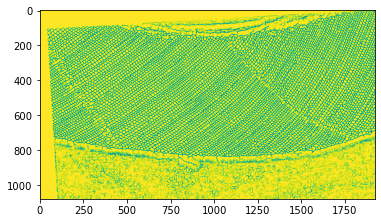

In [5]:
plt.imshow(im_list[191])

In [6]:
nuclei_list=[]
centroids_x_list=[]
centroids_y_list=[]
frame_num_list=[]
labels_list=[]

for i in tqdm(range(len(im_list))):
    #watershed segmentation
    nuclei, _=watershed_segmentation(im_list[i])
    
    #centroids extraction
    centroids_y, centroids_x, labels=extract_centroids(nuclei)
    
    #frame number
    frame_num=np.ones(len(centroids_y), dtype="int32")*i
    
    #save results
    nuclei_list.append(nuclei)
    centroids_y_list.extend(centroids_y)
    centroids_x_list.extend(centroids_x)
    frame_num_list.extend(frame_num)
    labels_list.extend(labels)
    
#convert to np.array
nuclei_list=np.asarray(nuclei_list)
centroids_y_list=np.asarray(centroids_y_list)
centroids_x_list=np.asarray(centroids_x_list)
frame_num_list=np.asarray(frame_num_list)
labels_list=np.asarray(labels_list)

#delete im_list and release memory
del im_list
gc.collect()

100%|█████████████████████████████████████████| 192/192 [05:40<00:00,  1.77s/it]


0

In [89]:
np.savez_compressed('./seg_results/r-H-5_for_tracking.npz',
                    nuclei_list=nuclei_list,
                    centroids_y_list=centroids_y_list, 
                    centroids_x_list=centroids_x_list,
                    frame_num_list=frame_num_list,
                    labels_list=labels_list)

In [6]:
tracking_data = np.load('./seg_results/r-H-5_for_tracking.npz')

In [7]:
nuclei_list=tracking_data['nuclei_list']
centroids_y_list=tracking_data['centroids_y_list']
centroids_x_list=tracking_data['centroids_x_list']
frame_num_list=tracking_data['frame_num_list']
labels_list=tracking_data['labels_list']

In [8]:
#make dataframe object for trackpy
features_data=np.vstack((centroids_y_list, centroids_x_list, frame_num_list, labels_list)).T
features_frame=pd.DataFrame(features_data, columns=["y", "x", "frame", "label"])

features_frame

,y,x,frame,label
0,2.000000,282.500000,0.0,1.0
1,6.395349,341.720917,0.0,2.0
2,3.444444,1428.222168,0.0,3.0
3,1.750000,1514.375000,0.0,4.0
4,2.562500,1543.875000,0.0,5.0
...,...,...,...,...
3212761,1076.500000,1700.500000,191.0,14223.0
3212762,1076.750000,138.375000,191.0,14224.0
3212763,1077.000000,648.000000,191.0,14225.0
3212764,1077.000000,1735.000000,191.0,14226.0


In [9]:
# perform the Crocker-Grier linking algorithm with trackpy
t1 = time.time() 

search_range= 3
track_result = tp.link_df(features_frame, search_range, memory=0)
#tp.plot_traj(track_result, superimpose=im_list[0])

t2 = time.time()

print(str(t2-t1)+" sec")

Frame 191: 14227 trajectories present.
37.71135997772217 sec


In [10]:
#set check number
check_number=len(np.unique(track_result["frame"]))

#count the frequency of each particle in all frames
particle_num_list, counts=np.unique(track_result["particle"], return_counts=True)
    
#filtering dataframe based on above-extracted particle num
track_result_filtered=track_result[track_result.particle.isin(np.where(counts==check_number)[0])]

In [11]:
track_result_filtered

,y,x,frame,label,particle
9312,758.174622,1237.359741,0,9313.0,2152
9313,758.024780,1484.089111,0,9314.0,2153
9316,757.157410,377.324066,0,9317.0,2156
9320,759.323792,837.638123,0,9321.0,2160
9321,759.362061,855.982788,0,9322.0,2161
...,...,...,...,...,...
3203280,449.876465,853.205872,191,4742.0,16821
3203281,451.566132,1610.365112,191,4743.0,16390
3203282,452.620087,1658.519653,191,4744.0,16247
3203283,450.339630,1828.691772,191,4745.0,13538


In [12]:
# check common particles 
common_existed_paricle_numbers = []
for frame in tqdm(range(len(np.unique(track_result["frame"])))):
    _, counts = np.unique(track_result[track_result["frame"]<=frame].particle, return_counts=True)
    common_existed_paricle_number = len(np.where(counts==frame+1)[0])
    common_existed_paricle_numbers.append(common_existed_paricle_number)

100%|█████████████████████████████████████████| 192/192 [00:17<00:00, 10.68it/s]


Text(0, 0.5, 'Existence of connected points')

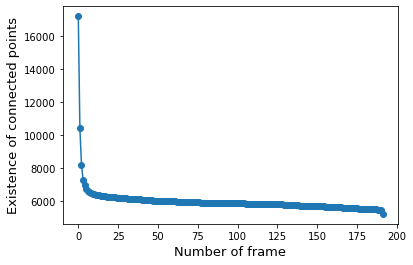

In [13]:
plt.plot(common_existed_paricle_numbers, 'o-')
#plt.xlim(0)
plt.xlabel('Number of frame', fontsize=13)
plt.ylabel('Existence of connected points',fontsize=13)

In [15]:
# set threshold number
threshold = 30

In [16]:
# to find common particles exist at frame #30
_, counts = np.unique(track_result[track_result["frame"]<=threshold].particle, return_counts=True)
track_result_filtered_redo = track_result[track_result.particle.isin(np.where(counts==threshold+1)[0])]

In [17]:
track_result_filtered_redo

,y,x,frame,label,particle
9311,756.625000,1221.889648,0,9312.0,2151
9312,758.174622,1237.359741,0,9313.0,2152
9313,758.024780,1484.089111,0,9314.0,2153
9314,757.751465,1562.437866,0,9315.0,2154
9315,757.263733,1777.500000,0,9316.0,2155
...,...,...,...,...,...
3203280,449.876465,853.205872,191,4742.0,16821
3203281,451.566132,1610.365112,191,4743.0,16390
3203282,452.620087,1658.519653,191,4744.0,16247
3203283,450.339630,1828.691772,191,4745.0,13538


In [18]:
#extract particle num satisfying check number
nuclei_true = extract_cell_tracking_result(nuclei_list, track_result_filtered_redo, check_number)

100%|█████████████████████████████████████████| 192/192 [01:14<00:00,  2.57it/s]


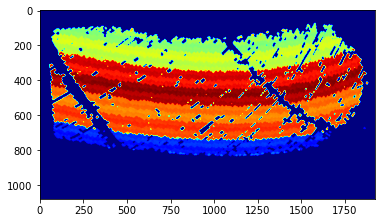

In [23]:
# check the accuarcy of tracking algorithm
ani = video(nuclei_true)
HTML(ani.to_html5_video())

In [19]:
# collect all parameters
area_lists = []
ecc_lists = []
major_axis_lists=[]
minor_axis_lists=[]
vert_lists=[]
hori_lists=[]
feret_lists=[]

for i in tqdm(range(check_number)):
    label=np.asarray([label for label in np.unique(nuclei_true[:,:,i])])
    props=regionprops(np.int32(nuclei_true[:,:,i]))
    
    #calculate each param
    area=np.asarray([props[j].area for j in range(len(props))])
    ecc=np.asarray([props[j].eccentricity for j in range(len(props))])
    major_axis=np.asarray([props[j].major_axis_length for j in range(len(props))])
    minor_axis=np.asarray([props[j].minor_axis_length for j in range(len(props))])
    vert=np.asarray([props[j].bbox[2] for j in range(len(props))])-np.asarray([props[j].bbox[0] for j in range(len(props))])
    hori=np.asarray([props[j].bbox[3] for j in range(len(props))])-np.asarray([props[j].bbox[1] for j in range(len(props))])
    feret=np.asarray([props[j].feret_diameter_max for j in range(len(props))])
    
    area_list = np.stack((label[1:], area), axis=-1)
    ecc_list = np.stack((label[1:], ecc), axis=-1)
    major_axis_list = np.stack((label[1:], major_axis), axis=-1)
    minor_axis_list = np.stack((label[1:], minor_axis), axis=-1)
    vert_list = np.stack((label[1:], vert), axis=-1)
    hori_list = np.stack((label[1:], hori), axis=-1)
    feret_list = np.stack((label[1:], feret), axis=-1)
    
    area_lists.append(area_list)
    ecc_lists.append(ecc_list)
    major_axis_lists.append(major_axis_list)
    minor_axis_lists.append(minor_axis_list)
    vert_lists.append(vert_list)
    hori_lists.append(hori_list)
    feret_lists.append(feret_list)

100%|█████████████████████████████████████████| 192/192 [05:47<00:00,  1.81s/it]


In [21]:
# collect all changing rate
area_change_lists = []
ecc_change_lists = []
major_axis_change_lists=[]
minor_axis_change_lists=[]
vert_change_lists=[]
hori_change_lists=[]
feret_change_lists=[]

for i in tqdm(range(check_number)):
    target_list_area = area_lists_array[i]
    first_list_area = area_lists_array[0]
    selected_list_area = first_list_area[np.where(first_list_area[:,:1]==np.intersect1d(first_list_area[:,:1], target_list_area[:,:1]))[0]]
    area_change = ((target_list_area[:,1:2] - selected_list_area[:,1:2])/selected_list_area[:,1:2])*100
    area_change_list = np.stack((target_list_area[:,:1][:,0], area_change[:,0]), axis=-1)
    
    target_list_ecc = ecc_lists_array[i]
    first_list_ecc = ecc_lists_array[0]
    selected_list_ecc = first_list_ecc[np.where(first_list_ecc[:,:1]==np.intersect1d(first_list_ecc[:,:1], target_list_ecc[:,:1]))[0]]
    ecc_change = ((target_list_ecc[:,1:2] - selected_list_ecc[:,1:2])/selected_list_ecc[:,1:2])*100
    ecc_change_list = np.stack((target_list_ecc[:,:1][:,0], ecc_change[:,0]), axis=-1)
    
    target_list_major_axis = major_axis_lists_array[i]
    first_list_major_axis = major_axis_lists_array[0]
    selected_list_major_axis = first_list_major_axis[np.where(first_list_major_axis[:,:1]==np.intersect1d(first_list_major_axis[:,:1], target_list_major_axis[:,:1]))[0]]
    major_axis_change = ((target_list_major_axis[:,1:2] - selected_list_major_axis[:,1:2])/selected_list_major_axis[:,1:2])*100
    major_axis_change_list = np.stack((target_list_major_axis[:,:1][:,0], major_axis_change[:,0]), axis=-1)
    
    target_list_minor_axis = minor_axis_lists_array[i]
    first_list_minor_axis = minor_axis_lists_array[0]
    selected_list_minor_axis = first_list_minor_axis[np.where(first_list_minor_axis[:,:1]==np.intersect1d(first_list_minor_axis[:,:1], target_list_minor_axis[:,:1]))[0]]
    minor_axis_change = ((target_list_minor_axis[:,1:2] - selected_list_minor_axis[:,1:2])/selected_list_minor_axis[:,1:2])*100
    minor_axis_change_list = np.stack((target_list_minor_axis[:,:1][:,0], minor_axis_change[:,0]), axis=-1)
    
    target_list_vert = vert_lists_array[i]
    first_list_vert = vert_lists_array[0]
    selected_list_vert = first_list_vert[np.where(first_list_vert[:,:1]==np.intersect1d(first_list_vert[:,:1], target_list_vert[:,:1]))[0]]
    vert_change = ((target_list_vert[:,1:2] - selected_list_vert[:,1:2])/selected_list_vert[:,1:2])*100
    vert_change_list = np.stack((target_list_vert[:,:1][:,0], vert_change[:,0]), axis=-1)
    
    target_list_hori = hori_lists_array[i]
    first_list_hori = hori_lists_array[0]
    selected_list_hori = first_list_hori[np.where(first_list_hori[:,:1]==np.intersect1d(first_list_hori[:,:1], target_list_hori[:,:1]))[0]]
    hori_change = ((target_list_hori[:,1:2] - selected_list_hori[:,1:2])/selected_list_hori[:,1:2])*100
    hori_change_list = np.stack((target_list_hori[:,:1][:,0], hori_change[:,0]), axis=-1)
    
    target_list_feret = feret_lists_array[i]
    first_list_feret = feret_lists_array[0]
    selected_list_feret = first_list_feret[np.where(first_list_feret[:,:1]==np.intersect1d(first_list_feret[:,:1], target_list_feret[:,:1]))[0]]
    feret_change = ((target_list_feret[:,1:2] - selected_list_feret[:,1:2])/selected_list_feret[:,1:2])*100
    feret_change_list = np.stack((target_list_feret[:,:1][:,0], feret_change[:,0]), axis=-1)
    
    
    area_change_lists.append(area_change_list)
    ecc_change_lists.append(ecc_change_list)
    major_axis_change_lists.append(major_axis_change_list)
    minor_axis_change_lists.append(minor_axis_change_list)
    vert_change_lists.append(vert_change_list)
    hori_change_lists.append(hori_change_list)
    feret_change_lists.append(feret_change_list)

100%|█████████████████████████████████████████| 192/192 [02:18<00:00,  1.38it/s]


In [20]:
area_lists_array = np.asarray(area_lists,dtype=object)
ecc_lists_array = np.asarray(ecc_lists,dtype=object)
major_axis_lists_array = np.asarray(major_axis_lists,dtype=object)
minor_axis_lists_array = np.asarray(minor_axis_lists,dtype=object)
vert_lists_array = np.asarray(vert_lists,dtype=object)
hori_lists_array = np.asarray(hori_lists,dtype=object)
feret_lists_array = np.asarray(feret_lists,dtype=object)

In [22]:
area_change_lists_array = np.asarray(area_change_lists,dtype=object)
ecc_change_lists_array = np.asarray(ecc_change_lists,dtype=object)
major_axis_change_lists_array = np.asarray(major_axis_change_lists,dtype=object)
minor_axis_change_lists_array = np.asarray(minor_axis_change_lists,dtype=object)
vert_change_lists_array = np.asarray(vert_change_lists,dtype=object)
hori_change_lists_array = np.asarray(hori_change_lists,dtype=object)
feret_change_lists_array = np.asarray(feret_change_lists,dtype=object)

In [23]:
# save all arrays
# np.savez_compressed('./seg_results/r-H-5.npz', 
#                     area=area_lists_array, 
#                     ecc=ecc_lists_array,
#                     major=major_axis_lists_array,
#                     minor=minor_axis_lists_array,
#                     vert=vert_lists_array,
#                     hori=vert_lists_array,
#                     feret=feret_lists_array,
#                     area_change=area_change_lists_array,
#                     ecc_change=ecc_change_lists_array,
#                     major_change=major_axis_change_lists_array,
#                     minor_change=minor_axis_change_lists_array,
#                     vert_change=vert_change_lists_array,
#                     hori_change=hori_change_lists_array,
#                     feret_change=feret_change_lists_array)

#### Here is a exmaple to analyze the cell wall deformation histgram (the method was inspired by YK)

In [2]:
HR_list = np.load('./seg_results/r-H-5.npz',allow_pickle=True)

In [3]:
ecc_lists_array= HR_list['ecc']
ecc_change_lists_array = HR_list['ecc_change']

## select only the parameter value
ecc_change_lists_1d_array = np.asarray([np.hsplit(ecc_change_lists_array[num],[1])[1] 
                             for num in range(len(ecc_change_lists_array))])

## remove  nan and inf value
ecc_change_lists_1d_array_mod = np.asarray([np.nan_to_num(ecc_change_lists_1d_array[num],nan=0.0, posinf=0.0, neginf=0.0) 
                                           for num in range(len(ecc_change_lists_1d_array))])




/Users/chen/miniforge3/envs/dl-chen/lib/python3.9/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [4]:
## set condiction for selection
thr_min = -100
thr_max = 100

ecc_change_lists_1d_array_mod_cond = np.asarray([ecc_change_lists_1d_array_mod[num][np.logical_and(ecc_change_lists_1d_array_mod[num] > thr_min, ecc_change_lists_1d_array_mod[num] < thr_max )]
                                                for num in range(len(ecc_change_lists_1d_array_mod))])

In [1]:
# fig, ax = plt.subplots(1,4,figsize=(20,3))

# a = ax[0].hist(ecc_change_lists_1d_array_mod_cond[10],bins=200, histtype='bar', rwidth=10, density=True)
# #ax[0].set_xlim(-100,100)
# #ax[0].set_ylim(0,1500)
# b = ax[1].hist(ecc_change_lists_1d_array_mod_cond[20],bins=200, histtype='bar', rwidth=10, density=True)
# #ax[1].set_xlim(-100,100)
# #ax[1].set_ylim(0,1500)
# c = ax[2].hist(ecc_change_lists_1d_array_mod_cond[30],bins=200, histtype='bar', rwidth=10, density=True)
# #ax[2].set_xlim(-100,100)
# #ax[2].set_ylim(0,1500)
# d = ax[3].hist(ecc_change_lists_1d_array_mod_cond[54],bins=200, histtype='bar', rwidth=10, density=True)
# #ax[3].set_xlim(-100,100)
# #ax[3].set_ylim(0,1500)

In [6]:
values = []
for i in tqdm(range(len(ecc_change_lists_1d_array_mod)-1)):
    hist, bin_edges = np.histogram(ecc_change_lists_1d_array_mod_cond[i+1], bins=100, range=(-50, 50), density=False)
    value_yvalue = hist
    values.append(value_yvalue)

100%|███████████████████████████████████████| 191/191 [00:00<00:00, 6580.52it/s]


In [7]:
np.asarray(values).shape

(191, 100)

In [26]:
# plt.figure(figsize=(7,7))
# plt.imshow(np.asarray(values), cmap='gist_ncar')
# #plt.axis('off')
# plt.colorbar()
# #plt.savefig('histo_ecc_HR.png',bbox_inches='tight', pad_inches=0.1,dpi=600)

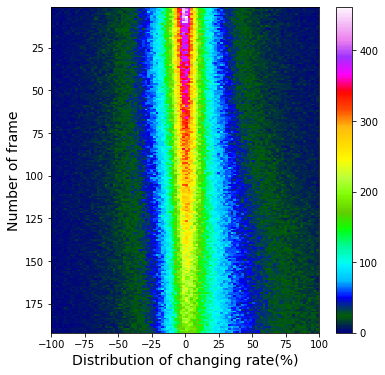

In [27]:
## with conducting the bending test, the disctribution eccentricy shift to the plus direction, which indicates
## the shear defomration of wood cell wall .... 

fig, ax = plt.subplots(figsize=(6,6))

mesh = ax.imshow(np.asarray(values), cmap=plt.cm.gist_ncar, interpolation='none', extent=[-100,100,192,1])
ax.set_aspect('auto')
ax.set_ylabel('Number of frame',fontsize=14)
ax.set_xlabel('Distribution of changing rate(%)', fontsize=14)
fig.colorbar(mesh)

In [61]:
#create parameter maps
result_area_map=result_visualization(nuclei_true, track_result_filtered, area_lists_array)
result_ecc_map=result_visualization(nuclei_true, track_result_filtered, ecc_lists_array)
result_major_map=result_visualization(nuclei_true, track_result_filtered, major_axis_lists_array)
result_minor_map=result_visualization(nuclei_true, track_result_filtered, minor_axis_lists_array)
result_vert_map=result_visualization(nuclei_true, track_result_filtered, vert_lists_array)
result_hori_map=result_visualization(nuclei_true, track_result_filtered, hori_lists_array)
result_feret_map=result_visualization(nuclei_true, track_result_filtered, feret_lists_array)

100%|█████████████████████████████████████████| 192/192 [08:43<00:00,  2.72s/it]


In [75]:
#create change rate maps
result_area_change_rate_map=result_visualization(nuclei_true, track_result_filtered, area_change_lists_array)
result_ecc_change_rate_map=result_visualization(nuclei_true, track_result_filtered, ecc_change_lists_array)
result_major_change_rate_map=result_visualization(nuclei_true, track_result_filtered, major_axis_change_lists_array)
result_minor_change_rate_map=result_visualization(nuclei_true, track_result_filtered, minor_axis_change_lists_array)
result_vert_change_rate_map=result_visualization(nuclei_true, track_result_filtered, vert_change_lists_array)
result_hori_change_rate_map=result_visualization(nuclei_true, track_result_filtered, hori_change_lists_array)
result_feret_change_rate_map=result_visualization(nuclei_true, track_result_filtered, feret_change_lists_array)

100%|█████████████████████████████████████████| 192/192 [07:45<00:00,  2.42s/it]


In [77]:
## save created map
np.savez_compressed('./seg_results/r-H-5_map.npz',
                    nuclei=nuclei_true,
                    area=result_area_map, 
                    ecc=result_ecc_map,
                    major=result_major_map,
                    minor=result_minor_map,
                    vert=result_vert_map,
                    hori=result_hori_map,
                    feret=result_feret_map,
                    area_change=result_area_change_rate_map,
                    ecc_change=result_ecc_change_rate_map,
                    major_change=result_major_change_rate_map,
                    minor_change=result_minor_change_rate_map,
                    vert_change=result_vert_change_rate_map,
                    hori_change=result_hori_change_rate_map,
                    feret_change=result_feret_change_rate_map)

In [78]:
# #create parameter maps
# result_area_map=result_visualization(nuclei_true, track_result_filtered, area_lists)
# result_ecc_map=result_visualization(nuclei_true, track_result_filtered, ecc_lists)
# result_major_map=result_visualization(nuclei_true, track_result_filtered, major_axis_lists)
# result_minor_map=result_visualization(nuclei_true, track_result_filtered, minor_axis_lists)
# result_vert_map=result_visualization(nuclei_true, track_result_filtered, vert_lists)
# result_hori_map=result_visualization(nuclei_true, track_result_filtered, hori_lists)
# result_feret_map=result_visualization(nuclei_true, track_result_filtered, feret_lists)

# #create change rate maps
# result_area_change_rate_map=result_visualization(nuclei_true, track_result_filtered, area_change_lists)
# result_ecc_change_rate_map=result_visualization(nuclei_true, track_result_filtered, ecc_change_lists)
# result_major_change_rate_map=result_visualization(nuclei_true, track_result_filtered, major_change_lists)
# result_minor_change_rate_map=result_visualization(nuclei_true, track_result_filtered, minor_change_lists)
# result_vert_change_rate_map=result_visualization(nuclei_true, track_result_filtered, vert_change_lists)
# result_hori_change_rate_map=result_visualization(nuclei_true, track_result_filtered, hori_change_lists)
# result_feret_change_rate_map=result_visualization(nuclei_true, track_result_filtered, feret_change_lists)

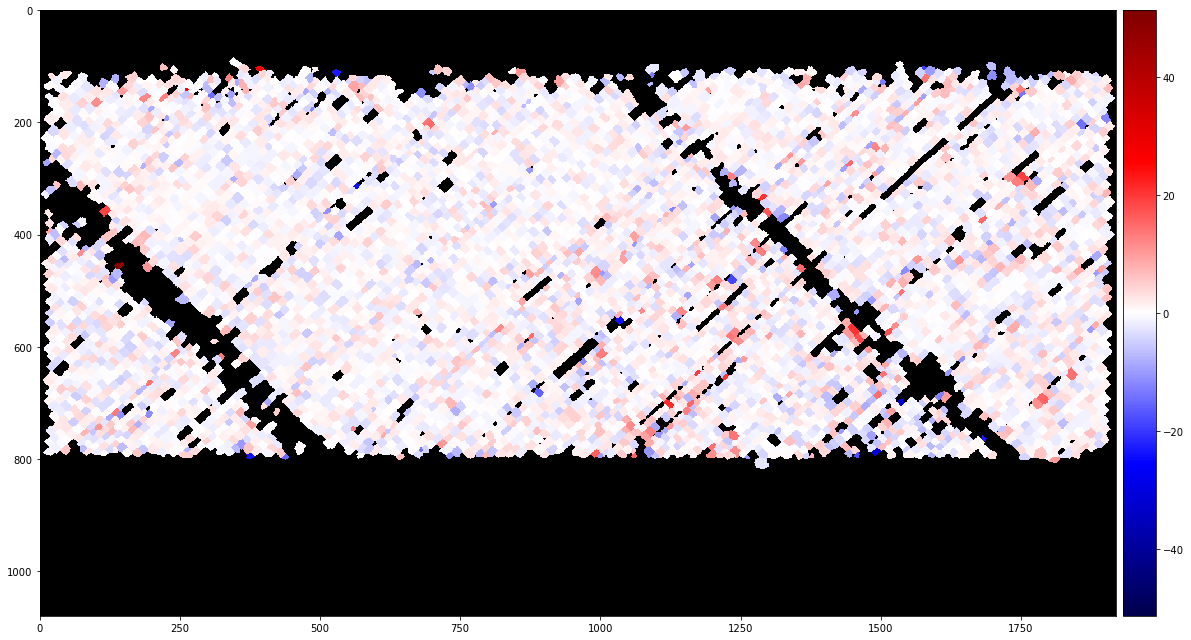

In [86]:
num = 11
dsiplay = result_major_change_rate_map

lim_min = np.max(np.abs(dsiplay[:,:,num]))*-1
lim_max = np.max(np.abs(dsiplay[:,:,num]))

fig = plt.figure(figsize = (20,20))
ax = fig.add_subplot(111)
ax.set_aspect('equal')
ax.invert_yaxis()

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.1)

cm = plt.cm.seismic.copy()
cm.set_bad((0, 0, 0, 1))

mesh = ax.pcolormesh(np.ma.array(dsiplay[:,:,num], mask=nuclei_true[:,:,num]==0), cmap = cm)
mesh.set_clim(lim_min,lim_max)

fig.colorbar(mesh,cax=cax)

In [87]:
def map_video(change_rate_map,nuclei_true):
    dsiplay = change_rate_map

    lim_min = np.max(np.abs(dsiplay[:,:,-1]))*-1
    lim_max = np.max(np.abs(dsiplay[:,:,-1]))

    fig = plt.figure()

    ax = fig.add_subplot(111)
    ax.set_aspect('equal')
    ax.invert_yaxis()

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="3%", pad=0.3)

    cm = plt.cm.seismic.copy()
    cm.set_bad((0, 0, 0, 1))

    mesh = ax.pcolormesh(dsiplay[:,:,0], cmap = cm)
    mesh.set_clim(lim_min, lim_max)
    fig.colorbar(mesh,cax=cax)

    def updatefig(j):
        mesh.set_array(np.ma.array(dsiplay[:,:,j], mask=nuclei_true[:,:,j]==0))
        return [mesh]


    ani = animation.FuncAnimation(fig, updatefig, frames=change_rate_map.shape[2], interval=20, blit=True)
    return(ani)



def map_video_custom(change_rate_map, nuclei_true, lim_min, lim_max):
    dsiplay = change_rate_map

    lim_min = lim_min
    lim_max = lim_max

    fig = plt.figure()

    ax = fig.add_subplot(111)
    ax.set_aspect('equal')
    ax.invert_yaxis()

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="3%", pad=0.3)

    cm = plt.cm.seismic.copy()
    cm.set_bad((0, 0, 0, 1))

    mesh = ax.pcolormesh(dsiplay[:,:,0], cmap = cm)
    mesh.set_clim(lim_min, lim_max)
    fig.colorbar(mesh,cax=cax)
    
    def updatefig(j):
        mesh.set_array(np.ma.array(dsiplay[:,:,j], mask=nuclei_true[:,:,j]==0))
        return [mesh]

    
    ani = animation.FuncAnimation(fig, updatefig, frames=result_vert_change_rate_map.shape[2], interval=20, blit=True)
    return(ani)

In [28]:
# ani = map_video(result_feret_change_rate_map, nuclei_true)
# HTML(ani.to_html5_video())